### This file loads, merges and cleans Eden Tenant Data 

In [1]:
import pandas as pd
import numpy as np
import os
import xlrd
import re
from functools import reduce
from itertools import groupby
from matplotlib import pyplot as plt
import pandas_dedupe
plt.show()
import seaborn as sns; sns.set()
import altair as alt
alt.data_transformers.disable_max_rows()
import warnings
warnings.filterwarnings('ignore')
from fuzzywuzzy import fuzz
pd.options.display.float_format = '{:}'.format #get rid of scientific notation 

import eden_data_functions #this .py file holds the majority of the functions for this analysis 
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

Get and clean sheet names from excel files

In [5]:
may2020_sept2020_location = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/TenantLeasePayments_Trending_(Active)_May_2020_Sept_2020.xlsx"
may2019_sept2019_location = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/Tenant_Lease_Payments_May 2019_Sept_2019.xlsx"

other_months_2020_location = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/Eden_2020_ Tenant_Lease_Payments_.zactive.xlsx"
other_months_2019_location = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/Eden_2019_ Tenant_Lease_Payments_.zactive.xlsx"

In [12]:
may2020_sept2020_sheet_names = eden_data_functions.get_sheet_names(may2020_sept2020_location)
may2019_sept2019_sheet_names = eden_data_functions.get_sheet_names(may2019_sept2019_location)
other_months_2020_sheet_names = eden_data_functions.get_sheet_names(other_months_2020_location)
other_months_2019_sheet_names = eden_data_functions.get_sheet_names(other_months_2019_location)

# need to drop data from earlier in months where we have double data (e.g., May 10,15 and May 31, keeping just end of month)
may2020_sept2020_sheet_names = [x for x in may2020_sept2020_sheet_names if not "15" in x]
may2020_sept2020_sheet_names = [x for x in may2020_sept2020_sheet_names if not "10" in x]

Load in and merge data 

In [42]:
first_month = eden_data_functions.read_in_check_status(other_months_2019_location,other_months_2019_sheet_names[0]) 

full_data = [first_month, eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[1]),
           eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[2]),
           eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[3]),
           eden_data_functions.read_in(may2019_sept2019_location,may2019_sept2019_sheet_names[0]),
           eden_data_functions.read_in(may2019_sept2019_location,may2019_sept2019_sheet_names[1]),
           eden_data_functions.read_in(may2019_sept2019_location,may2019_sept2019_sheet_names[2]),
           eden_data_functions.read_in(may2019_sept2019_location,may2019_sept2019_sheet_names[3]),
           eden_data_functions.read_in(may2019_sept2019_location,may2019_sept2019_sheet_names[4]),
           eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[4]),
           eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[5]),
           eden_data_functions.read_in(other_months_2019_location,other_months_2019_sheet_names[6]),
           #2020
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[1]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[1]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[2]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[3]),
           eden_data_functions.read_in(may2020_sept2020_location,may2020_sept2020_sheet_names[0]),
           eden_data_functions.read_in(may2020_sept2020_location,may2020_sept2020_sheet_names[1]),
           eden_data_functions.read_in(may2020_sept2020_location,may2020_sept2020_sheet_names[2]),
           eden_data_functions.read_in(may2020_sept2020_location,may2020_sept2020_sheet_names[3]),
           eden_data_functions.read_in(may2020_sept2020_location,may2020_sept2020_sheet_names[4]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[4]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[5]),
           eden_data_functions.read_in(other_months_2020_location,other_months_2020_sheet_names[6])]

In [198]:
full_eden.Name.unique().shape

(7810,)

In [43]:
#This lambda function then merges all the dataframes from df_list together 
full_eden = reduce(lambda left,right: pd.merge(left,right,on='key'), full_data)

Here I'm calling a preliminary cleaning function. It removes employee units as well as units that were not completed for the entirity of 2019-2020 (found by looking at Eden's website for properties with high vacencies in the data)

In [67]:
full_eden = eden_data_functions.filter_eden_rent_roll(full_eden)
#full_eden.to_csv("wide_eden_rental_dataset.csv")

In [172]:
#read in Eden residents to see if can match 
eden_residents = pd.read_csv("Eden2018_2019residents.csv")

In [122]:
#clean the data ADD FUNCTION HEADERS 
df_tenants_clean = eden_data_functions.clean_names(full_eden,"Name","Tenant")
eden_residents_clean = eden_data_functions.clean_names(eden_residents,"Member_Name","Tenant_Code",eden_tenants=False)

In [174]:
#filter eden residents by dropping duplicates, data that only exits in 2018, and those that are not heads of households
eden_residents_clean = eden_data_functions.filter_eden_resident(eden_residents_clean)

In [181]:
eden_merged = df_tenants_clean.merge(eden_residents_clean,on="Match",how="inner")
#without fuzzy matching, but after fixing location names, we get 4058 matched records 
len(eden_merged)

4058

In [225]:
#pd.set_option('display.max_rows', 8000) # we can manually inspect the match ratio if we reset rows we can see
merge_table_big = calc_matches(df_tenants_clean,eden_residents_clean)


In [226]:
merge_table_big.sort_values("score", ascending=False)

,player_name,match_name,score
0,rastersmargueritet0028148almondterrace,rastersmargueritet0028148almondterrace,100
3739,wolduhintontsehayt0013067801almafamilyapartments,wolduhintontsehayt0013067801almafamilyapartments,100
3737,osotonudiannat0013051801almafamilyapartments,osotonudiannat0013051801almafamilyapartments,100
3736,pashalidisathanasiost0013040801almafamilyapart...,pashalidisathanasiost0013040801almafamilyapart...,100
3735,pradoabrahamt0013081801almafamilyapartments,pradoabrahamt0013081801almafamilyapartments,100
3734,garciayvettet0013054801almafamilyapartments,garciayvettet0013054801almafamilyapartments,100
3733,solomonwondwossent0013036801almafamilyapartments,solomonwondwossent0013036801almafamilyapartments,100
3732,fengjit0013022801almafamilyapartments,fengjit0013022801almafamilyapartments,100
3731,guardadojesust0013045801almafamilyapartments,guardadojesust0013045801almafamilyapartments,100
3730,tangzhihongt0025143801almafamilyapartments,tangzhihongt0025143801almafamilyapartments,100


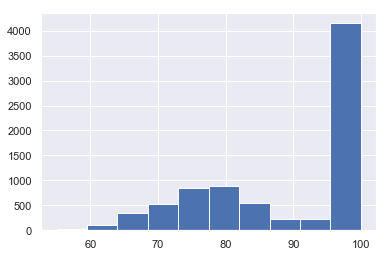

In [185]:
#examine distribution of match scores 
%matplotlib inline
merge_table_big.score.hist()

In [218]:
#merge data now using fuzzy matching 
eden_merged_fuzzy = eden_data_functions.keep_high_scores_and_merge(df_tenants_clean,eden_residents_clean,merge_table_big)

In [219]:
# drop and rename cols post merge 
eden_merged_fuzzy = eden_data_functions.drop_cols_post_merge(eden_merged_fuzzy)

In [216]:
#now we have 4046 Matches 
eden_merged_fuzzy.Match.nunique()

4046

In [221]:
#eden_merged_fuzzy.to_csv("2_1_21_Eden_Residents_Matched.csv")

In [300]:
eden_row_level = eden_data_functions.melt_rows(eden_merged_fuzzy)

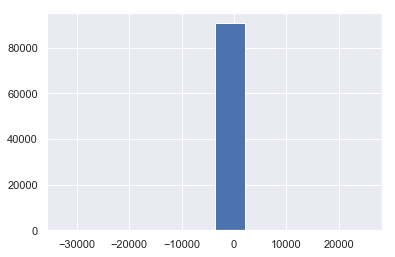

In [305]:
#clearly need to drop some outliers 
eden_row_level["Tenant Percent Collected"].hist()

In [316]:
#removing payment percentages greater than or less than 500 drops 235 of the ~90k entries 
len(eden_row_level) - len(eden_row_level[(eden_row_level["Tenant Percent Collected"]>-400)&(eden_row_level["Tenant Percent Collected"]<400)])

235

In [312]:
eden_row_level = eden_row_level[(eden_row_level["Tenant Percent Collected"]>-500)&(eden_row_level["Tenant Percent Collected"]<500)]

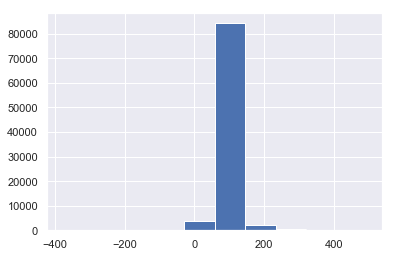

In [317]:
eden_row_level["Tenant Percent Collected"].hist()

In [318]:
eden_row_level.to_csv("2_1_21_eden_row_level_data.csv")